<a href="https://colab.research.google.com/github/ekramasif/Pepper-Disease-Classification-using-CNN/blob/main/Pepper_Disease_Classification_using_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import layers, Sequential
import pathlib

In [ ]:
dataset_dir = pathlib.Path('/content/drive/MyDrive/Datasets/PepperDisease')
print(dataset_dir)

/content/drive/MyDrive/Datasets/PepperDisease


In [ ]:
BATCH_SIZE = 32
IMAGE_HEIGHT = 256
IMAGE_WIDTH = 256
CHANNELS = 3

# Training dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
    directory=dataset_dir,
    batch_size=BATCH_SIZE,
    validation_split=0.2,
    subset='training',
    seed=42,
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
)

Found 2475 files belonging to 2 classes.
Using 1980 files for training.


In [ ]:
# Validation dataset
valid_ds = tf.keras.utils.image_dataset_from_directory(
    directory=dataset_dir,
    batch_size=BATCH_SIZE,
    validation_split=0.2,
    subset='validation',
    seed=42,
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
)

Found 2475 files belonging to 2 classes.
Using 495 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy']


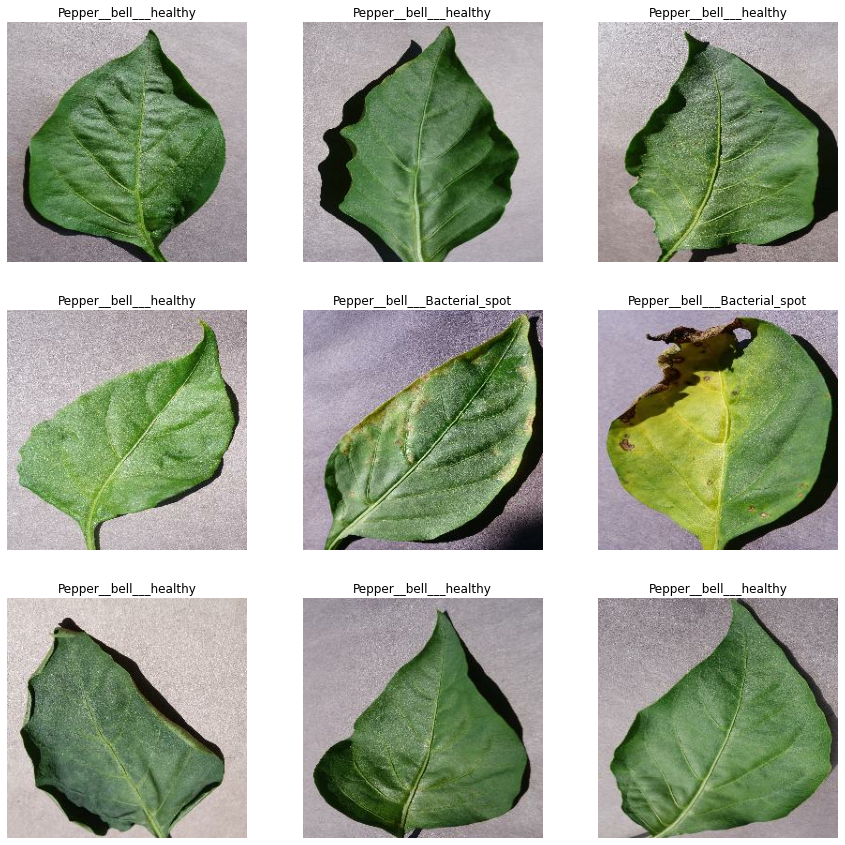

In [ ]:
plt.figure(figsize=(15,15))
for image, label in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(image[i].numpy().astype('uint8'))
        plt.title(class_names[label[i]])
        plt.axis('off')
        plt.tight_layout

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
valid_ds = valid_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
numb_classes = 2

model = Sequential([
    layers.Rescaling(1./255, input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, CHANNELS)),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(8, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(4, activation='relu'),
    layers.Dense(numb_classes)
])

In [ ]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 64)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      18464     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 16)        4

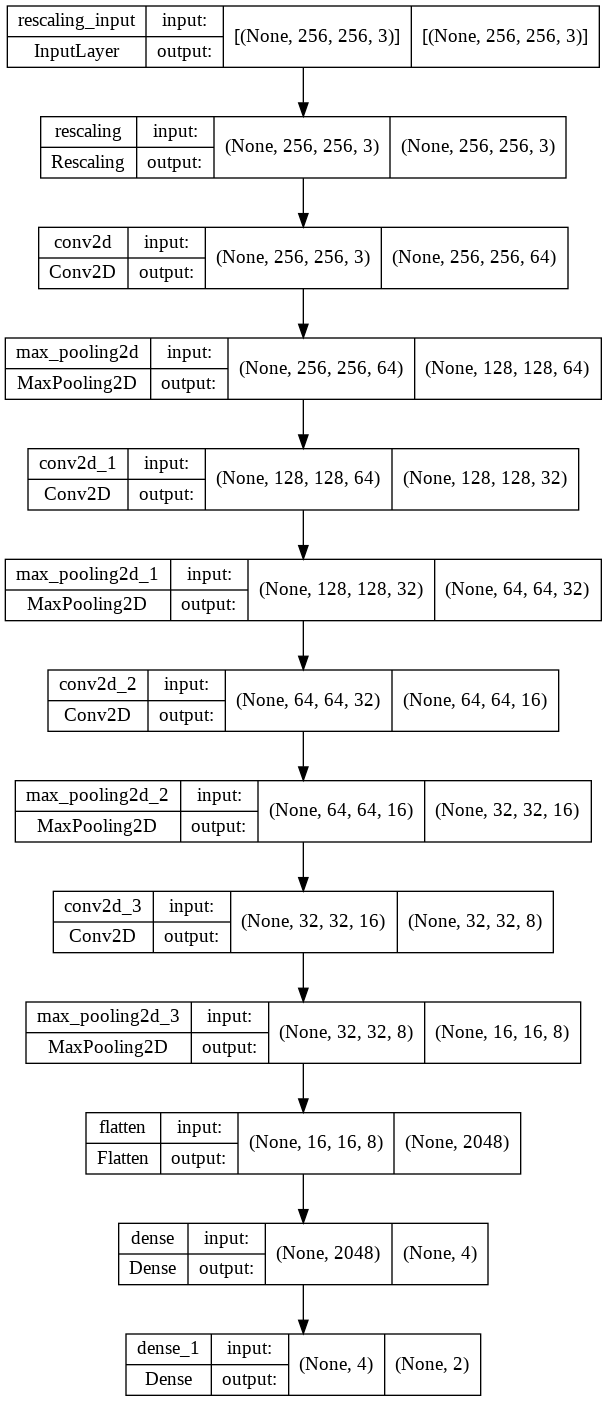

In [16]:
from keras.utils.vis_utils import plot_model
from IPython.display import Image
plot_model(model, to_file='CNN_model_plot.png', show_shapes=True, show_layer_names=True)
Image(retina=True, filename='CNN_model_plot.png')

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    restore_best_weights=True,
    patience=5,
    min_delta=0.02
)

In [ ]:
epochs=15

history = model.fit(
    train_ds,
    validation_data=valid_ds,
    epochs=epochs,
    batch_size=BATCH_SIZE,
    callbacks=[callback]
)

Epoch 1/15
62/62 [==============================] - 21s 142ms/step - loss: 0.6201 - accuracy: 0.6556 - val_loss: 0.4051 - val_accuracy: 0.8283
Epoch 2/15
62/62 [==============================] - 5s 87ms/step - loss: 0.3590 - accuracy: 0.8636 - val_loss: 0.1856 - val_accuracy: 0.9313
Epoch 3/15
62/62 [==============================] - 6s 90ms/step - loss: 0.1922 - accuracy: 0.9434 - val_loss: 0.0929 - val_accuracy: 0.9758
Epoch 4/15
62/62 [==============================] - 5s 82ms/step - loss: 0.1484 - accuracy: 0.9551 - val_loss: 0.0578 - val_accuracy: 0.9879
Epoch 5/15
62/62 [==============================] - 5s 82ms/step - loss: 0.0935 - accuracy: 0.9788 - val_loss: 0.0717 - val_accuracy: 0.9697
Epoch 6/15
62/62 [==============================] - 5s 82ms/step - loss: 0.0714 - accuracy: 0.9838 - val_loss: 0.0665 - val_accuracy: 0.9838
Epoch 7/15
62/62 [==============================] - 5s 83ms/step - loss: 0.0516 - accuracy: 0.9874 - val_loss: 0.0215 - val_accuracy: 0.9919
Epoch 8/15


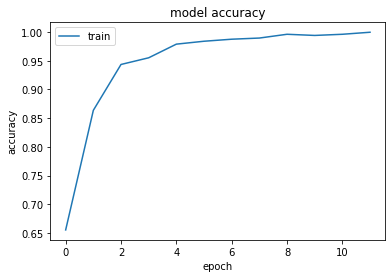

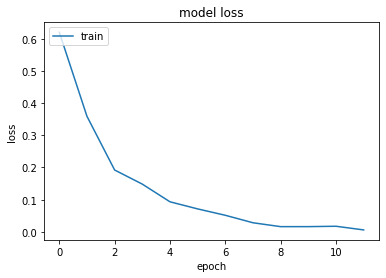

<Figure size 432x288 with 0 Axes>

In [20]:
from matplotlib import pyplot as plt
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()
plt.savefig('loss_curve.png')

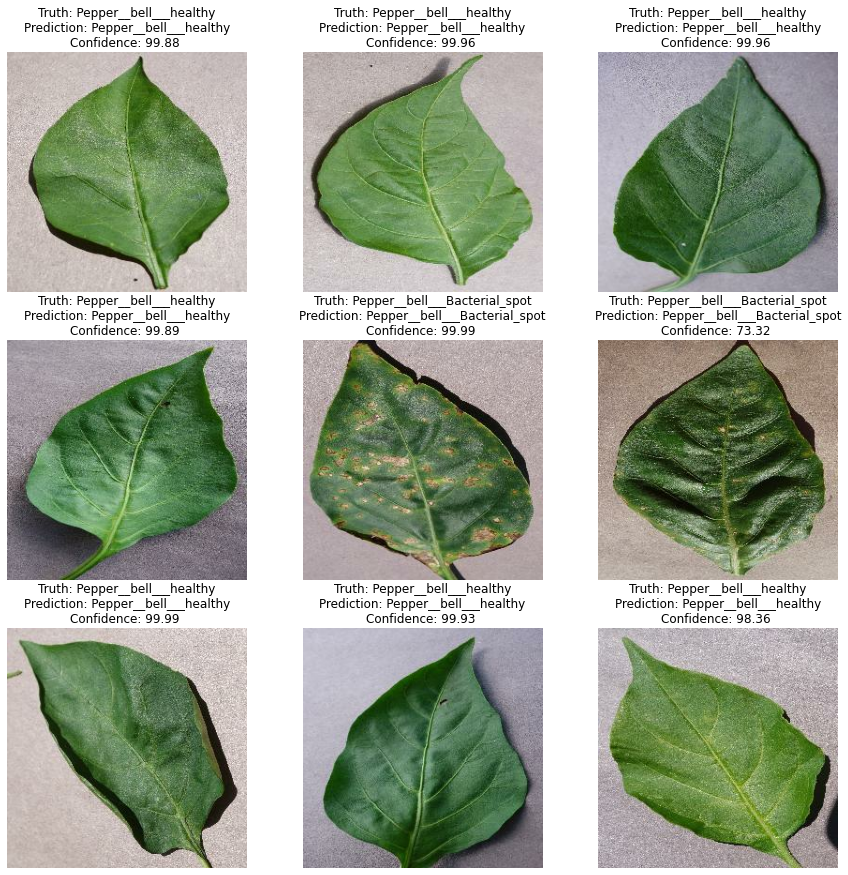

In [ ]:
# Take a look at some results
plt.figure(figsize=(15,15))

for img, label in valid_ds.take(1):
    for i in range(9):
        prediction = model.predict(img)
        score = tf.nn.softmax(prediction[i])
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(img[i].numpy().astype('uint8'))
        plt.title('Truth: ' + class_names[label[i]] +
                  "\n" + 'Prediction: ' + class_names[np.argmax(score)] + 
                  '\n' + 'Confidence: {:.2f} '.format(100 * np.max(score))),
        plt.axis('off'),
        plt.tight_layout